In [1]:
from network_simulation import NetworkSimulation
from utils import NetworkVisualization, get_selected_params, load_params_yaml, simulate_stn_intervention
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy

In [2]:
dt = 0.5

params_pop, params_conn_all = load_params_yaml('params1.yaml', dt=dt)

pops_no_stn = ['Proto', 'FSI', 'D2']
pop_lif = ['Proto', 'FSI', 'D2', 'STN_LIF']
pop_qif = ['Proto', 'FSI', 'D2', 'STN_QIF']

pop_params_no_stn, conn_params_no_stn = get_selected_params(params_pop, params_conn_all, pops_no_stn)
pop_params_lif, conn_params_lif = get_selected_params(params_pop, params_conn_all, pop_lif)
pop_params_qif, conn_params_qif = get_selected_params(params_pop, params_conn_all, pop_qif)

T = 6000
drop_time = 1000
seed = 422

bin_width = 2

In [3]:
print('Running without STN')
network_sim_no_stn = NetworkSimulation(pop_params_no_stn, conn_params_no_stn, T, dt, seed=seed)
network_sim_no_stn.simulate(drop_time=drop_time)

network_vis_no_stn = NetworkVisualization(network_sim_no_stn)

print('-'*50)
print('Running with LIF STN')
network_sim_lif = NetworkSimulation(pop_params_lif, conn_params_lif, T, dt, seed=seed)
network_sim_lif.simulate(drop_time=drop_time)

network_vis_lif = NetworkVisualization(network_sim_lif)

print('-'*50)
print('Running with QIF STN')
network_sim_qif = NetworkSimulation(pop_params_qif, conn_params_qif, T, dt, seed=seed)
network_sim_qif.simulate(drop_time=drop_time)

network_vis_qif = NetworkVisualization(network_sim_qif)

Running without STN
Average firing rate for Proto population: 47.30 Hz
Average firing rate for FSI population: 21.64 Hz
Average firing rate for D2 population: 2.42 Hz
--------------------------------------------------
Running with LIF STN
Average firing rate for Proto population: 48.77 Hz
Average firing rate for FSI population: 20.42 Hz
Average firing rate for D2 population: 2.57 Hz
Average firing rate for STN population: 18.81 Hz
--------------------------------------------------
Running with QIF STN
Average firing rate for Proto population: 48.19 Hz
Average firing rate for FSI population: 22.23 Hz
Average firing rate for D2 population: 2.57 Hz
Average firing rate for STN population: 16.19 Hz


(0.0, 40.0)

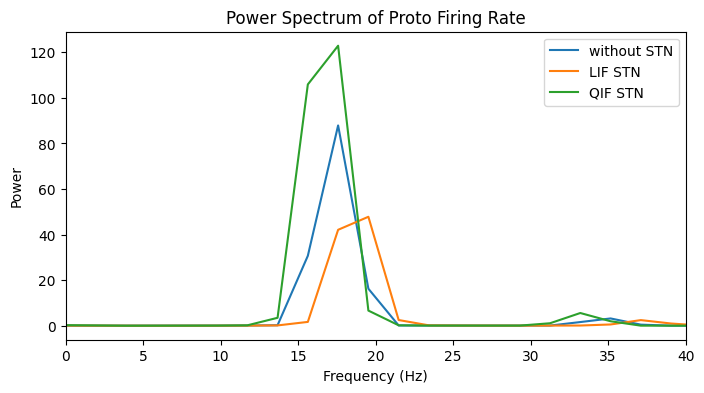

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

network_vis_no_stn.plot_power_spectrum(
        pop='Proto',
        bin_width=bin_width,
        drop_initial=drop_time,
        legend='without STN',
        ax=ax
    )

network_vis_lif.plot_power_spectrum(
        pop='Proto',
        bin_width=bin_width,
        drop_initial=drop_time,
        legend='LIF STN',
        ax=ax
    )

network_vis_qif.plot_power_spectrum(
        pop='Proto',
        bin_width=bin_width,
        drop_initial=drop_time,
        legend='QIF STN',
        ax=ax
    )

plt.legend()
plt.xlim(0,40)

STN inactive
Average firing rate for Proto population: 48.60 Hz
Average firing rate for FSI population: 21.45 Hz
Average firing rate for D2 population: 2.34 Hz
Average firing rate for STN population: 21.29 Hz
STN active
Average firing rate for Proto population: 49.31 Hz
Average firing rate for FSI population: 20.74 Hz
Average firing rate for D2 population: 2.45 Hz
Average firing rate for STN population: 19.89 Hz


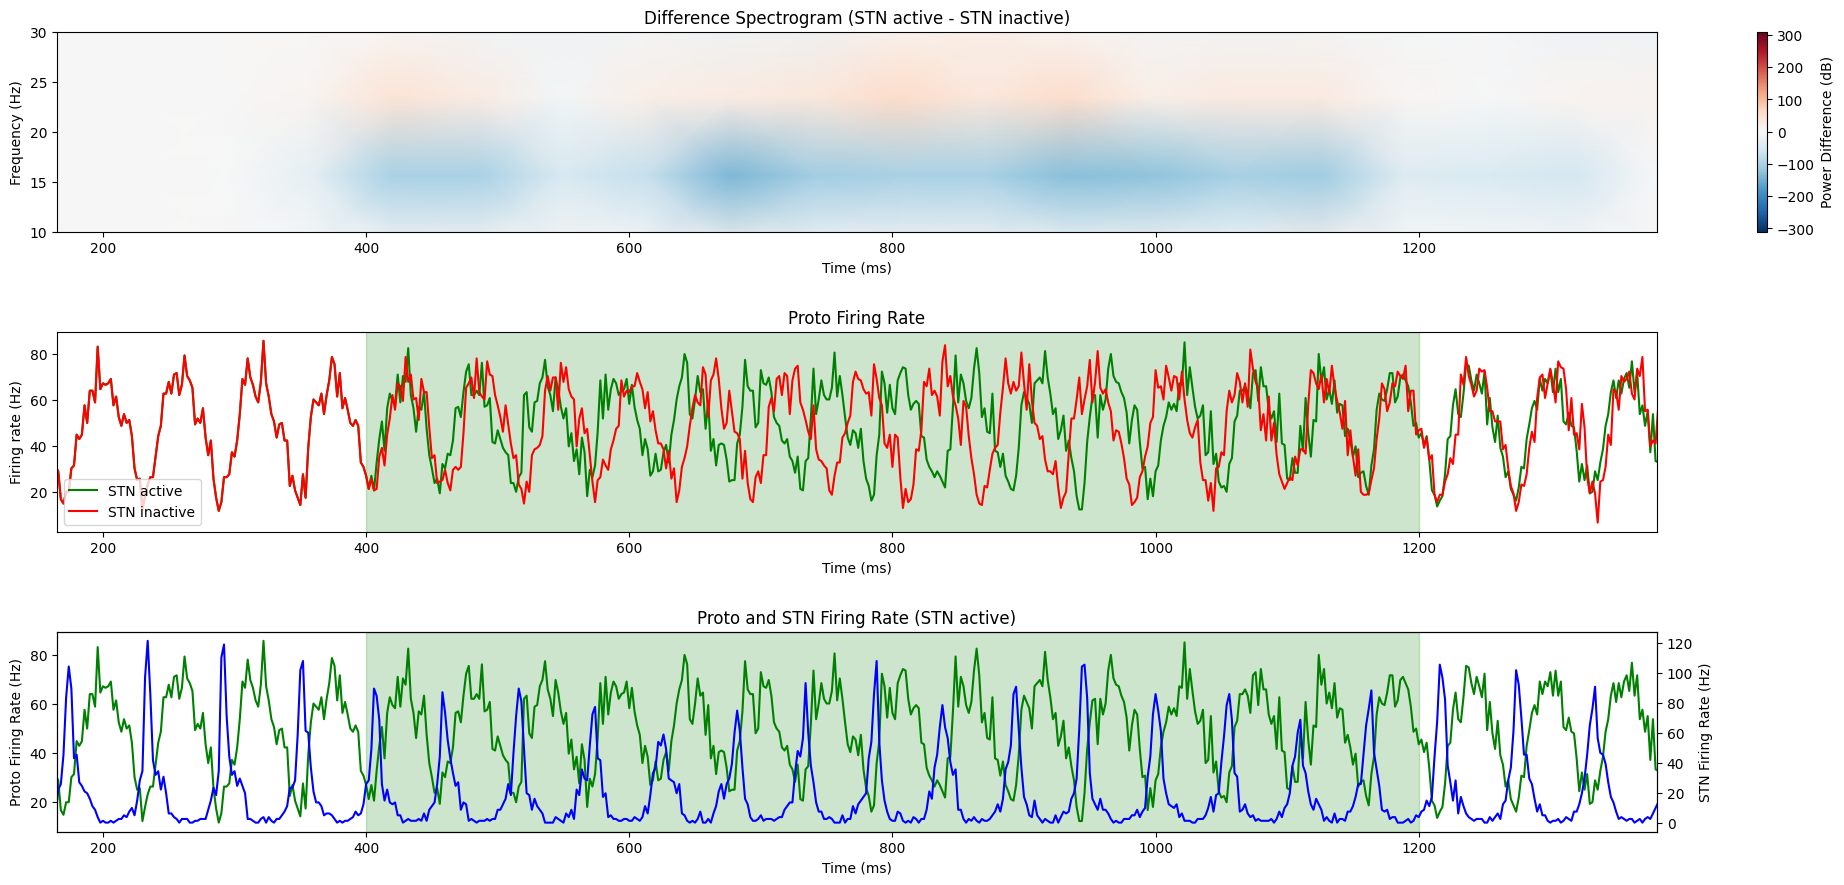

phase 1: -2.415536903682468, phase 2: 0.08012928796989628, diff: 2.495666191652364
143.0
Phase difference between Proto and STN during intervention: 143.0 degrees at 18.2 Hz


In [5]:
T = 1500

STN_start=400
STN_end=1200
colorbar_range = (-310, 310)

_, _ = simulate_stn_intervention(T, pop_params_lif, conn_params_lif, STN_start=STN_start, STN_end=STN_end, colorbar_range=colorbar_range)

STN inactive
Average firing rate for Proto population: 48.60 Hz
Average firing rate for FSI population: 21.45 Hz
Average firing rate for D2 population: 2.34 Hz
Average firing rate for STN population: 15.97 Hz
STN active
Average firing rate for Proto population: 48.87 Hz
Average firing rate for FSI population: 22.19 Hz
Average firing rate for D2 population: 2.42 Hz
Average firing rate for STN population: 15.86 Hz


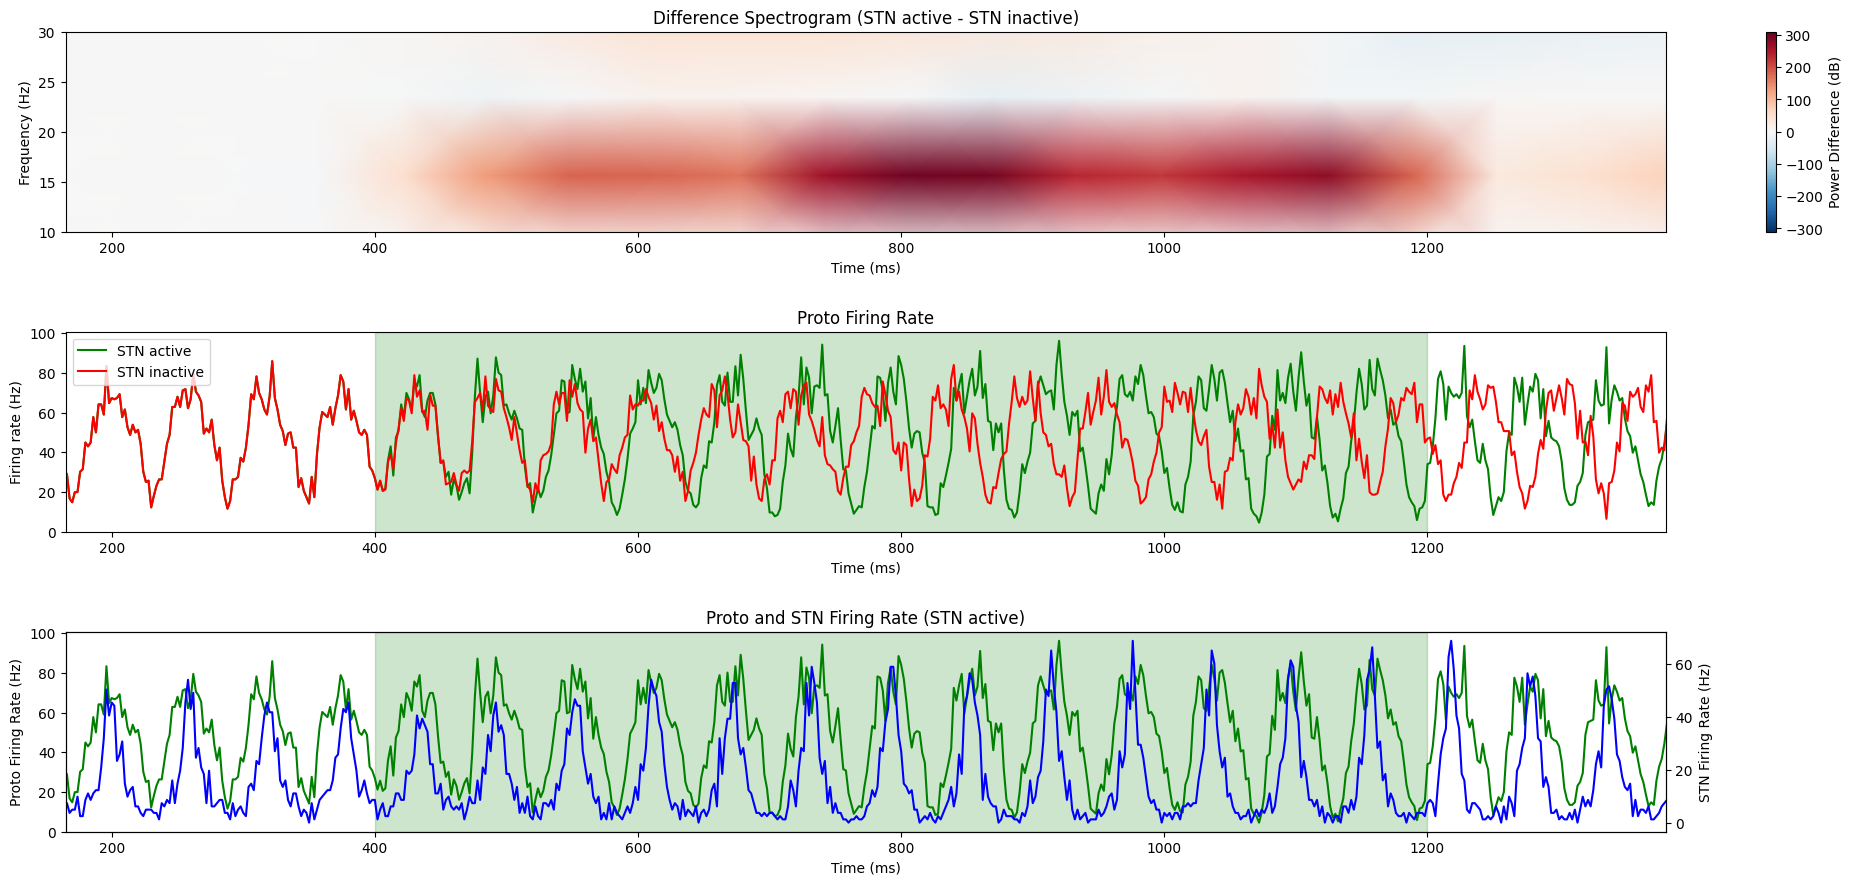

phase 1: -2.6413994893424397, phase 2: -2.48911408482344, diff: 0.15228540451899963
8.7
Phase difference between Proto and STN during intervention: 8.7 degrees at 16.4 Hz


In [6]:
_, _ = simulate_stn_intervention(T, pop_params_qif, conn_params_qif, STN_start=STN_start, STN_end=STN_end, colorbar_range=colorbar_range)

In [16]:
import os
import pickle

def run_current_sweep(label, I_list, pop_params, conn_params, T, dt, seed, drop_time, bin_width, save_dir='.'):
    """
    Run a parameter sweep over input current values and collect metrics.

    Parameters:
    -----------
    label : str
        Label for the sweep (used in filename)
    I_list : array-like
        List of input current values to sweep over
    pop_params : dict
        Population parameters dictionary
    conn_params : dict
        Connection parameters dictionary
    T : float
        Simulation time
    dt : float
        Time step
    seed : int
        Random seed
    drop_time : float
        Time to drop from beginning of simulation
    bin_width : float
        Bin width for analysis
    save_dir : str, optional
        Directory to save results (default: current directory)

    Returns:
    --------
    dict : Dictionary containing lists of results:
        - 'label': Label string
        - 'seed': Random seed used
        - 'I_list': Input current values
        - 'beta_power': Beta power values
        - 'ave_beta_freq': Average beta frequency values
        - 'firing_rate': Firing rate values
        - 'phase_diff': Phase difference values
    """

    # Create filename
    filename = f'{label}_{seed}.pkl'
    save_folder_dir = os.path.join(save_dir, 'data', 'sweep')
    if not os.path.exists(save_folder_dir):
        os.makedirs(save_folder_dir)
    filepath = os.path.join(save_folder_dir, filename)

    # Check if file already exists
    if os.path.exists(filepath):
        # print(f"File {filename} already exists. Loading existing results...")
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            # print(f"Successfully loaded results from {filename}")
            return results
        except Exception as e:
            print(f"Error loading file {filename}: {e}")
            print("Proceeding with new simulation...")

    # Run simulations if file doesn't exist or couldn't be loaded
    # print(f"Running new simulation for {filename}...")

    beta_power_list = []
    ave_beta_freq_list = []
    fr_list = []
    phase_diff_list = []

    for i, I in enumerate(I_list):
        # Create a copy to avoid modifying original parameters
        pop_params_copy = pop_params.copy()
        pop_params_copy['STN']['I'] = I

        # Run simulation
        network_sim = NetworkSimulation(pop_params_copy, conn_params, T, dt, seed=seed)
        network_sim.simulate(drop_time=drop_time, print_fr=False)

        # Calculate firing rate
        fr = network_sim.get_average_firing_rate('STN')

        # Calculate metrics
        network_vis = NetworkVisualization(network_sim)
        ave_beta_freq, beta_power = network_vis.calculate_beta_power('Proto', bin_width=bin_width)
        phase_diff, *_ = network_vis.calculate_phase_difference('Proto', 'STN', bin_width=bin_width)

        # Store results
        fr_list.append(fr)
        beta_power_list.append(beta_power)
        ave_beta_freq_list.append(ave_beta_freq)
        phase_diff_list.append(phase_diff)

    # Prepare results dictionary
    results = {
        'label': label,
        'seed': seed,
        'I_list': list(I_list),  # Convert to list for JSON compatibility if needed
        'beta_power': beta_power_list,
        'ave_beta_freq': ave_beta_freq_list,
        'firing_rate': fr_list,
        'phase_diff': phase_diff_list
    }

    # Save results
    try:
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)

        with open(filepath, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to {filename}")

    except Exception as e:
        print(f"Error saving results to {filename}: {e}")

    return results

In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def run_multi_seed_sweep(label, I_list, pop_params, conn_params, T, dt, seeds, drop_time, bin_width, save_dir='.'):
    """
    Run parameter sweep over multiple seeds and collect results.

    Parameters:
    -----------
    label : str
        Label for the sweep
    I_list : array-like
        List of input current values
    pop_params : dict
        Population parameters
    conn_params : dict
        Connection parameters
    T : float
        Simulation time
    dt : float
        Time step
    seeds : list
        List of random seeds to use
    drop_time : float
        Time to drop from beginning
    bin_width : float
        Bin width for analysis
    save_dir : str
        Directory to save results

    Returns:
    --------
    dict : Dictionary with aggregated results including means and standard errors
    """

    all_results = []

    # Run sweep for each seed
    for seed in tqdm(seeds, desc=f"Running {label} sweep"):
        result = run_current_sweep(label, I_list, pop_params, conn_params,
                                 T, dt, seed, drop_time, bin_width, save_dir)
        all_results.append(result)

    # Aggregate results across seeds
    aggregated = aggregate_results(all_results, label)

    # Save aggregated results
    agg_filename = f'{label}_aggregated.pkl'
    save_folder_dir = os.path.join(save_dir, 'data', 'sweep')
    if not os.path.exists(save_folder_dir):
        os.makedirs(save_folder_dir)
    agg_filepath = os.path.join(save_folder_dir, agg_filename)

    try:
        os.makedirs(os.path.dirname(agg_filepath), exist_ok=True)
        with open(agg_filepath, 'wb') as f:
            pickle.dump(aggregated, f)
        # print(f"\nAggregated results saved to {agg_filename}")
    except Exception as e:
        print(f"Error saving aggregated results: {e}")

    return aggregated

def aggregate_results(results_list, label):
    """
    Aggregate results from multiple seeds.

    Parameters:
    -----------
    results_list : list
        List of result dictionaries from different seeds
    label : str
        Label for the aggregated results

    Returns:
    --------
    dict : Aggregated results with means, standard deviations, and standard errors
    """

    if not results_list:
        return {}

    # Get the structure from the first result
    first_result = results_list[0]
    n_seeds = len(results_list)
    n_points = len(first_result['I_list'])

    # Initialize arrays to collect data
    metrics = ['beta_power', 'ave_beta_freq', 'firing_rate', 'phase_diff']
    collected_data = {metric: np.zeros((n_seeds, n_points)) for metric in metrics}

    # Collect data from all seeds
    for i, result in enumerate(results_list):
        for metric in metrics:
            collected_data[metric][i, :] = result[metric]

    # Calculate statistics
    aggregated = {
        'label': label,
        'seeds': [r['seed'] for r in results_list],
        'n_seeds': n_seeds,
        'I_list': first_result['I_list'],
    }

    for metric in metrics:
        data = collected_data[metric]
        aggregated[f'{metric}_mean'] = np.mean(data, axis=0)
        aggregated[f'{metric}_std'] = np.std(data, axis=0)
        aggregated[f'{metric}_sem'] = np.std(data, axis=0) / np.sqrt(n_seeds)  # Standard error
        aggregated[f'{metric}_all'] = data  # Keep all individual results

    return aggregated

def plot_with_error_bars(x_data, y_data, y_error, label, ax=None, color=None, marker='o', linestyle='-', capsize=3):
    """
    Plot data with discrete error bars.

    Parameters:
    -----------
    x_data : array
        X-axis data
    y_data : array
        Y-axis mean data
    y_error : array
        Y-axis error data (standard error or standard deviation)
    label : str
        Label for the plot
    color : str, optional
        Color for the plot
    marker : str
        Marker style
    linestyle : str
        Line style
    capsize : float
        Size of error bar caps
    """
    # Plot the main line and markers


    # Plot error bars with reduced alpha (paler)
    if ax is None:
        line = plt.plot(x_data, y_data, label=label, color=color, marker=marker,
                   linestyle=linestyle, linewidth=2, markersize=6)

        # Get the color that was actually used
        line_color = line[0].get_color()
        plt.errorbar(x_data, y_data, yerr=y_error,
                    color=line_color, marker='none', linestyle='none',
                    capsize=capsize, capthick=1, alpha=0.4, elinewidth=1)
    else:
        line = ax.plot(x_data, y_data, label=label, color=color, marker=marker,
                   linestyle=linestyle, linewidth=2, markersize=6)

        # Get the color that was actually used
        line_color = line[0].get_color()
        ax.errorbar(x_data, y_data, yerr=y_error,
                    color=line_color, marker='none', linestyle='none',
                    capsize=capsize, capthick=1, alpha=0.4, elinewidth=1)


In [18]:
sweep_input_dict = {}

# Sweep through LIF
sweep_input_dict['LIF'] = {'I_list': np.arange(8.7, 9.45, 0.1), 'pop_params': pop_params_lif, 'conn_params': conn_params_lif}

# Heterogeneity in LIF STN
pop_params_lif_het = copy.deepcopy(pop_params_lif)
pop_params_lif_het['STN']['I_dev'] = 0.1
I_lif_het_list = np.arange(7.6, 9.1, 0.2)
sweep_input_dict['LIF_het'] = {'I_list': I_lif_het_list, 'pop_params': pop_params_lif_het, 'conn_params': conn_params_lif}

# QIF
sweep_input_dict['QIF'] = {'I_list': np.arange(65, 68.6, 0.25), 'pop_params': pop_params_qif, 'conn_params': conn_params_qif}

# Heterogeneity in QIF STN
pop_params_qif_het = copy.deepcopy(pop_params_qif)
pop_params_qif_het['STN']['I_dev'] = 0.01
I_qif_het_list = np.arange(64.5, 68.6, 0.5)
sweep_input_dict['QIF_het'] = {'I_list': I_qif_het_list, 'pop_params': pop_params_qif_het, 'conn_params': conn_params_qif}

# Without Proto to STN connection
pop_params_no_proto_stn = copy.deepcopy(pop_params_lif_het)
conn_params_no_proto_stn = copy.deepcopy(conn_params_lif)
conn_params_no_proto_stn[-2]['g'] = 0
I_no_proto_stn_list = np.arange(7,8.05,0.2)
sweep_input_dict['No_Proto_STN'] = {'I_list': I_no_proto_stn_list, 'pop_params': pop_params_no_proto_stn, 'conn_params': conn_params_no_proto_stn}


In [19]:
seeds = np.arange(422, 432)
T = 5000
drop_time = 1000

results = {}
for sweep_name in tqdm(sweep_input_dict.keys(), desc="Running sweeps"):
    sweep_config = sweep_input_dict[sweep_name]

    results[sweep_name] = run_multi_seed_sweep(
        sweep_name,
        sweep_config['I_list'],
        sweep_config['pop_params'],
        sweep_config['conn_params'],
        T, dt, seeds, drop_time, bin_width
    )

Running LIF sweep: 100%|██████████| 10/10 [00:00<00:00, 9986.44it/s]

Running LIF_het sweep: 100%|██████████| 10/10 [00:00<00:00, 9981.68it/s]

Running QIF sweep: 100%|██████████| 10/10 [00:00<00:00, 4832.70it/s]

Running QIF_het sweep: 100%|██████████| 10/10 [00:00<00:00, 5003.94it/s]

Running sweeps: 100%|██████████| 5/5 [00:00<00:00, 261.62it/s]


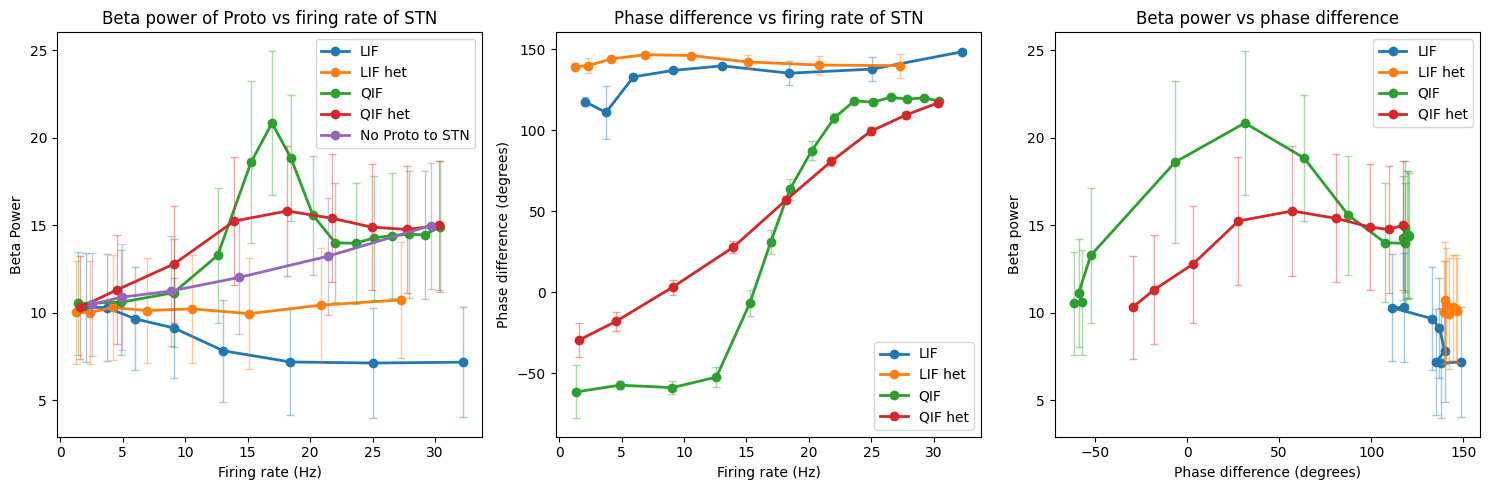

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define nice labels for the plot
plot_labels = {
    'LIF': 'LIF',
    'QIF': 'QIF',
    'No_Proto_STN': 'No Proto to STN',
    'LIF_het': 'LIF het',
    'QIF_het': 'QIF het'
}

# Plot all results with error bars
for sweep_name, result in results.items():
    label = plot_labels.get(sweep_name, sweep_name)  # Use sweep_name as fallback if not in dict

    plot_with_error_bars(result['firing_rate_mean'],
                         result['beta_power_mean'],
                         result['beta_power_sem'],
                         label,
                         ax=axs[0])

axs[0].set_ylabel('Beta Power')
axs[0].set_xlabel('Firing rate (Hz)')
axs[0].set_title('Beta power of Proto vs firing rate of STN')
axs[0].legend()
plt.tight_layout()


for sweep_name, result in results.items():
    if sweep_name == 'No_Proto_STN':
        continue
    label = plot_labels.get(sweep_name, sweep_name)  # Use sweep_name as fallback if not in dict

    plot_with_error_bars(result['firing_rate_mean'],
                         result['phase_diff_mean'],
                         result['phase_diff_sem'],
                         label,
                         ax=axs[1])

axs[1].set_ylabel('Phase difference (degrees)')
axs[1].set_xlabel('Firing rate (Hz)')
axs[1].set_title(f'Phase difference vs firing rate of STN')
axs[1].legend()
plt.tight_layout()

for sweep_name, result in results.items():
    if sweep_name == 'No_Proto_STN':
        continue
    label = plot_labels.get(sweep_name, sweep_name)  # Use sweep_name as fallback if not in dict

    plot_with_error_bars(result['phase_diff_mean'],
                         result['beta_power_mean'],
                         result['beta_power_sem'],
                         label,
                         ax=axs[2])

axs[2].set_xlabel('Phase difference (degrees)')
axs[2].set_ylabel('Beta power')
axs[2].set_title(f'Beta power vs phase difference')
axs[2].legend()
plt.tight_layout()
plt.show()



In [ ]:
for sweep_name, result in results.items():
    label = plot_labels.get(sweep_name, sweep_name)  # Use sweep_name as fallback if not in dict

    plot_with_error_bars(result['firing_rate_mean'],
                         result['ave_beta_freq_mean'],
                         result['ave_beta_freq_sem'],
                         label)

plt.ylabel('Beta frequency (Hz)')
plt.xlabel('Firing rate (Hz)')
plt.title(f'Average beta frequency of Proto vs firing rate of STN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))

# Define markers and colors for each model type
markers = {'LIF': 'o', 'QIF': 's', 'No_Proto_STN': '^', 'LIF_het': 'D', 'QIF_het': 'v'}
colors = {'LIF': 'blue', 'QIF': 'red', 'No_Proto_STN': 'green', 'LIF_het': 'purple', 'QIF_het': 'orange'}

for sweep_name, result in results.items():
    label = plot_labels.get(sweep_name, sweep_name)

    # Get all individual beta power and phase difference values
    beta_power_values = result['beta_power_all'].flatten()
    phase_diff_values = result['phase_diff_all'].flatten()

    # Plot scatter points
    plt.scatter(phase_diff_values, beta_power_values,
                label=label,
                marker=markers.get(sweep_name, 'o'),
                color=colors.get(sweep_name, None),
                alpha=0.7,
                s=50)

plt.xlabel('Phase difference (degrees)')
plt.ylabel('Beta Power')
plt.title('Beta Power vs Phase Difference (all seeds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()